In [1]:
import math, random

import gym
import numpy as np
from matplotlib import pyplot
import pdb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.replay_buffer import ReplayBuffer
from pyemd import * 

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Cart Pole Environment</h2>

In [4]:
env_id = "CartPole-v0"
env = gym.make(env_id)

STOP = False

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


<h3> Noisy Networks for Exploration</h3>

In [5]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

<h1>C-51 Algorithm</h1>
<h2>A Distributional Perspective on Reinforcement Learning</h2>

In [6]:
class CategoricalDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(CategoricalDQN, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 128)
        self.linear2 = nn.Linear(128, 128)
        self.noisy1 = NoisyLinear(128, 512)
        self.noisy2 = NoisyLinear(512, self.num_actions * self.num_atoms)
        
        self.theta = nn.Parameter(torch.FloatTensor(1, 1, num_atoms).normal_(), requires_grad=True)
        
    def forward(self, x, stop=False):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        x = F.softmax(x.view(-1, self.num_atoms), dim=-1).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(Vmin, Vmax, num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [7]:
def projection_distribution(next_state, rewards, dones, EMD=False):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    # output of target_model is a **normalized** dist
    next_dist_raw  = target_model(next_state).data.cpu()

    next_dist      = next_dist_raw * support
    next_action    = next_dist.sum(2).max(1)[1]
    next_action    = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist      = next_dist.gather(1, next_action).squeeze(1)
    next_dist_raw  = next_dist_raw.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long() # lower bound of each bin
    u  = b.ceil().long()  # upper bound of each bin
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long() \
                    .unsqueeze(1).expand(batch_size, num_atoms)


    proj_dist = torch.zeros(next_dist.size())  
    
    if EMD: next_dist = next_dist_raw 
    if STOP : pdb.set_trace()
    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float()) ).view(-1))
    
    # this doesn't handle the case if u == b == l (which would simply discard it)
    # for EMD only
    if EMD: 
        next_dist_eq = u == l
        next_dist_eq = next_dist * next_dist_eq.float()
        proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist_eq).view(-1))
        
    return proj_dist

In [8]:
num_atoms = 51
Vmin = 0   # -500 # -10
Vmax = 200 # -100 # 10

current_model = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

current_model_ = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model_  = CategoricalDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
# target_model.eval()

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
    current_model_ = current_model.cuda()
    target_model_  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=5e-4)

replay_buffer = ReplayBuffer(10000)

<h3>Synchronize current policy net and target net</h3>

In [9]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

### EMD Loss for categorical data

In [10]:
class Categorical_EMD():
    def __init__(self):
        # we need to build a distance matrix (num_atoms x num_atoms) giving us the distance between the atoms
        distance_matrix = np.zeros((num_atoms, num_atoms))

        for i in range(num_atoms):
            for j in range(num_atoms):
                distance_matrix[i, j] = max(i - j, j - i) 
        
        self.dist_matrix = distance_matrix
        self.dist_tensor = Variable(torch.from_numpy(distance_matrix)).float().unsqueeze(0)
        
    def get_transport_plans(self, source_dist, target_dist):
        all_plans = []
        for i in range(source_dist.size(0)):
            try:
                transport_plan = Variable(torch.from_numpy(np.array(emd_with_flow(target_dist[i].double().numpy(), 
                                                                              source_dist[i].double().data.numpy(),                                                                self.dist_matrix)[1])))
            except:
                pdb.set_trace()
            all_plans += [transport_plan]
        
        return torch.stack(all_plans, dim=0).float()
    
    def loss(self, source_dist, target_dist, Print=False):
        assert len(source_dist.size()) == len(target_dist.size()) == 2 # bs x num_atoms
        
        transport_plans = self.get_transport_plans(source_dist, target_dist)
        
        # if Print: print transport_plans[0]
        
        # source_dist = source_dist.unsqueeze(0).repeat(num_atoms, 1)
        source_dist = source_dist.unsqueeze(1).repeat(1, num_atoms, 1)

        normalized_plan = transport_plans / source_dist.detach()
        cost = normalized_plan * self.dist_tensor * source_dist
        return cost.sum()
    
    # helper to get the CDF at every atom given a categorical distribution
    def get_cdf(self, categorical_dist):
        '''
        categorical dist : (num_atoms, ) shape
        '''
        # dist = categorical_dist.unsqueeze(0).expand(num_atoms, -1)
        dist = categorical_dist.unsqueeze(1).expand(-1, num_atoms, -1)
        cdf = (dist * mask.unsqueeze(0)).sum(dim=-1)
        return cdf

    def Cramer_Loss(self, source_distribution, target_distribution, Print=False):
        source_cdf = self.get_cdf(source_distribution)
        target_cdf = self.get_cdf(Variable(target_distribution))
        delta = source_cdf - target_cdf
        return (delta ** 2).sum() ** (.5)

# for cramer distance
NUM_ATOMS = num_atoms
# we need a num_atoms x num_atoms mask to calculate the CDFs at every point
mask = np.zeros((NUM_ATOMS, NUM_ATOMS))
for i in range(NUM_ATOMS + 1):
    for j in range(i):
        mask[i-1, j] = 1
        
mask = Variable(torch.from_numpy(mask).float())
    
    
emd_loss = Categorical_EMD()


In [11]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    
def plot_dists(pmf_target, pmf_estim, epoch, save=False):
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    pyplot.bar(np.linspace(Vmin, Vmax, num_atoms), pmf_target, width=2., alpha=.5, label='target')
    pyplot.bar(np.linspace(Vmin, Vmax, num_atoms), pmf_estim, width=1.5, alpha=.5, label='estim')
    pyplot.title('distributions at iteration {}'.format(epoch))
    pyplot.legend()
    if save: 
        pyplot.savefig('emd/{}.png'.format(epoch))
    pyplot.show()


<h2>Computing Temporal Difference Loss</h2>

In [ ]:
def compute_td_loss(current_model, target_model, batch_size, plot=False, EMD=False):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done, EMD=EMD)

    dist = current_model(state)
    # import pdb; pdb.set_trace()
    
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    
    # loss = - (Variable(proj_dist) * dist.log()).sum(1).mean()
    
    # assert torch.abs(dist.sum() - proj_dist.sum()).data[0] < 1e-3, pdb.set_trace()
    # loss = torch.nn.KLDivLoss()(dist, Variable(proj_dist)).sum()
    # print 'proj dist', proj_dist
    # print 'dist     ', dist
    
    # normalize the distributions prior to computing the loss
    dist = dist / dist.sum(dim=-1, keepdim=True)
    proj_dist = proj_dist / proj_dist.sum(dim=-1, keepdim=True)
    
    
    Print = False
    if plot:
        plot_dists(proj_dist[0].numpy(), dist[0].data.numpy(), 0)
        Print = True
        # print 'source dist : ', dist[0]
        print 'source total prob : ', dist[0].sum()
        # print 'target dist : ', proj_dist[0]
        print 'target total prob : ', proj_dist[0].sum()
    
    if EMD: 
        loss = emd_loss.Cramer_Loss(dist, proj_dist, Print=Print)
    else: 
        loss = - (Variable(proj_dist) * dist.log()).sum(1).mean()
    
    if not plot:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        current_model.reset_noise()
        target_model.reset_noise()
    
    return loss

<h2>Training</h2>

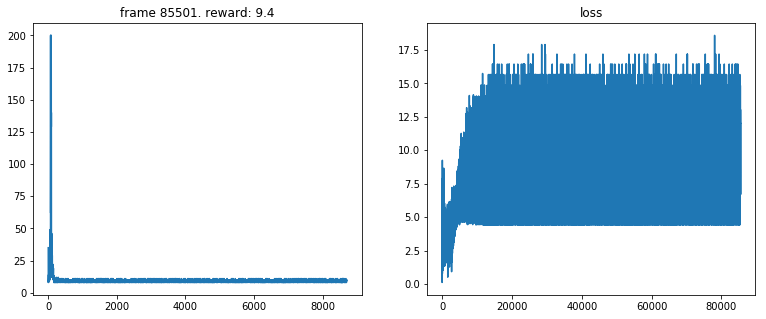

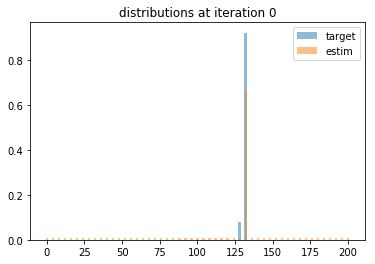

source total prob :  Variable containing:
 1
[torch.FloatTensor of size 1]

target total prob :  1.0
loss : 6.6908


In [ ]:
num_frames = 2000000
batch_size = 32
gamma      = 0.99

RENDER  = True
APPEND  = True
USE_EMD = True

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    model_choice = np.random.randint(1) # should be two 
    model  = current_model if model_choice == 0 else current_model_
    target = target_model  if model_choice == 0 else target_model_
    
    action = model.act(state)
    
    if RENDER : env.render()
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if RENDER: 
        # print('action : {}'.format(action))
        x = 2
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        RENDER = False
        STOP = False
        
    if len(replay_buffer) >= batch_size:
        loss = compute_td_loss(model, target, batch_size, EMD=USE_EMD)
        losses.append(loss.data[0])
        
    if frame_idx % 300 == 1:
        RENDER = True
        plot(frame_idx, all_rewards, losses)
        loss = compute_td_loss(model, target, batch_size, plot=True, EMD=USE_EMD)
        print('loss : {:.4f}'.format(loss.data[0]))

    if frame_idx % 200 == 0: # never update (debugging)
        target = target_model_ if model_choice == 1 else target_model
        update_target(model, target)
    
    if frame_idx % 10000 == 0: 
        x = 1

In [ ]:
[np.random.randint(2)  for _ in range(100)]